#### Input Analyzer – cleans and structures user input
#### LLM Processor – generates an answer
#### Formatter – formats the final output

In [1]:
import os
import json

from langgraph.graph import StateGraph, START, END
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from typing import TypedDict, Literal, Dict, Any, Annotated
import operator

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
def get_llm() -> AzureChatOpenAI:

    api_key = os.getenv("AZURE_OPENAI_KEY")
    api_version = os.getenv("AZURE_OPENAI_VERSION", "2024-02-15-preview")
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    azure_deployment = (
        os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
        or os.getenv("AZURE_OPENAI_DEPLOYMENT")
    )

    # ---- Validation ----
    missing = []
    if not api_key:
        missing.append("AZURE_OPENAI_KEY")
    if not azure_endpoint:
        missing.append("AZURE_OPENAI_ENDPOINT")
    if not azure_deployment:
        missing.append("AZURE_OPENAI_DEPLOYMENT_NAME")

    if missing:
        raise EnvironmentError(
            f"Missing required environment variables: {', '.join(missing)}"
        )

    # Normalize endpoint
    azure_endpoint = azure_endpoint.rstrip("/")

    return AzureChatOpenAI(
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
        azure_deployment=azure_deployment,
        temperature=0.0,
    )


# Example usage
llm = get_llm()
# llm.invoke(
#     f"Answer the following question clearly:\n explain Molecule"
# )


In [3]:
from typing import TypedDict

class WorkflowState(TypedDict):
    user_input: str
    cleaned_input: str
    llm_response: str
    final_output: str


In [4]:
def analyze_input(state: WorkflowState) -> WorkflowState:
    cleaned = state["user_input"].strip().lower()
    return {
        **state,
        "cleaned_input": cleaned
    }


In [5]:
from langchain_openai import AzureChatOpenAI

def llm_processor(state: WorkflowState) -> WorkflowState:
    response = llm.invoke(
        f"Answer the following question clearly:\n{state['cleaned_input']}"
    )
    return {
        **state,
        "llm_response": response.content
    }


In [6]:
def format_output(state: WorkflowState) -> WorkflowState:
    formatted = f"✅ Final Answer:\n\n{state['llm_response']}"
    return {
        **state,
        "final_output": formatted
    }


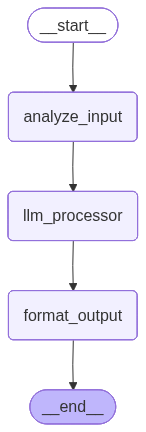

In [7]:
from langgraph.graph import StateGraph, START,END

workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("analyze_input", analyze_input)
workflow.add_node("llm_processor", llm_processor)
workflow.add_node("format_output", format_output)

# Define sequential flow
workflow.set_entry_point("analyze_input")
workflow.add_edge("analyze_input", "llm_processor")
workflow.add_edge("llm_processor", "format_output")
workflow.add_edge("format_output", END)

# Compile graph
app = workflow.compile()
app


In [8]:
result = app.invoke({
    "user_input": "Explain about proton, nutron & electron in simple terms"
})

print(result["final_output"])


✅ Final Answer:

Sure! Here's a simple explanation of protons, neutrons, and electrons:

1. **Proton**:  
   - A proton is a tiny particle found in the center of an atom, called the nucleus.  
   - It has a **positive charge** (+).  
   - Protons help determine what element an atom is. For example, an atom with 1 proton is hydrogen, and an atom with 2 protons is helium.  

2. **Neutron**:  
   - A neutron is another tiny particle found in the nucleus of an atom, alongside protons.  
   - It has **no charge** (neutral).  
   - Neutrons help stabilize the atom by keeping the protons from repelling each other (since protons are positively charged and would push away from each other without neutrons).  

3. **Electron**:  
   - Electrons are very small particles that move around the nucleus in regions called "shells" or "orbitals."  
   - They have a **negative charge** (-).  
   - Electrons are responsible for chemical reactions and bonding between atoms.  

In summary:  
- Protons (+) an